In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict
import json
import tensorflow as tf
import keras

2023-05-02 19:42:26.737609: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 19:42:27.449799: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/grinenko/anaconda3/envs/the/lib/
2023-05-02 19:42:27.449857: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/grinenko/anaconda3/envs/the/lib/
2023-05-02 19:42:27.449863: W tensorflow/compiler/

In [3]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)

In [4]:

import Clustering
import Forecasting

2023-05-02 19:42:28.339612: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 19:42:28.822274: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46308 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:81:00.0, compute capability: 8.6


In [5]:
W=20

In [6]:
from tensorflow.python.client import device_lib 
device_lib.list_local_devices() 

2023-05-02 19:42:30.917406: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /device:GPU:0 with 46308 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:81:00.0, compute capability: 8.6


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11653025825367546516
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 48558374912
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 18160073326861908386
 physical_device_desc: "device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:81:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [7]:
data = pd.read_csv("pulp_and_paper.csv", sep=";")#, parse_dates=['time']) #, nrows=10)

In [8]:
data.head()

,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
0,5/1/99 0:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,5/1/99 0:02,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
2,5/1/99 0:04,0,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,...,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
3,5/1/99 0:06,0,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,...,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
4,5/1/99 0:08,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0


In [9]:
data.shape

(18398, 63)

In [10]:
# data.hist()

In [11]:
K = 1
df = data.groupby(data.index // K).mean() #усреднение
df_np = df.to_numpy()

/tmp/ipykernel_275361/2168214760.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = data.groupby(data.index // K).mean() #усреднение


In [12]:
df_np.shape

(18398, 62)

In [13]:
dataset = df_np[:, 1:]
dataset_y = df_np[:, 0]
# dataset = np.concatenate((dataset[:, :8], dataset[:, 9:]), axis=1)
dataset.shape

(18398, 61)

Отбор переменных

In [14]:
#удаление константных
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(0.00001)
dataset1 = selector.fit_transform(dataset) 
dataset1.shape

(18398, 60)

In [15]:
set(data.columns[2:]) - set(selector.get_feature_names_out(input_features=data.columns[2:]))

{'x33'}

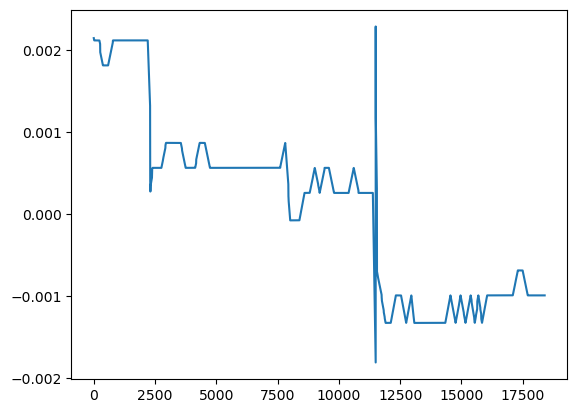

In [16]:
plt.plot(data.x33)

In [17]:
#категориальная переменная (пока ничего не делаю)
data.x28.value_counts()

96     6574
82     4378
118    2646
139    1807
84     1313
112    1235
93      419
51       26
Name: x28, dtype: int64

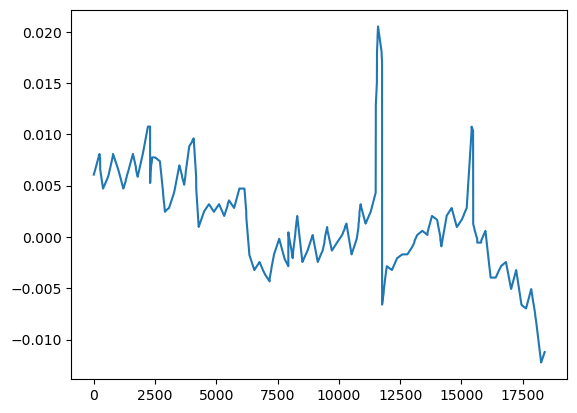

In [18]:
plt.plot(data.x60)

In [19]:
dataset = dataset1
dataset.shape

(18398, 60)

Кластеризация

In [20]:
dataset = dataset[:]

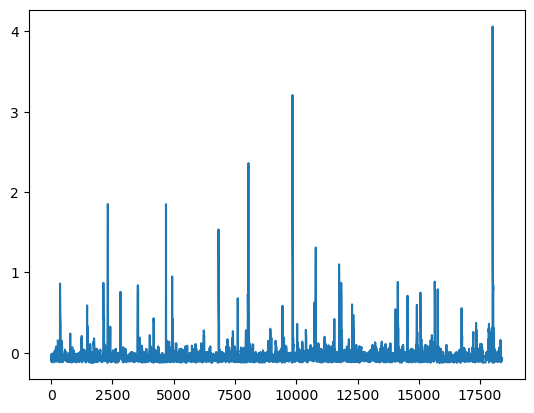

In [21]:
plt.plot(dataset[..., 8])

**Параметры кластеризации**

In [22]:
window_sizes_for_clustering = [1, 5, 10]#[1, 5, 10, 15] #[1, 3, 5, 10, 15]
Ns_clusters = [2, 5, 9, 11] #, 3 5, 7]#[2, 5, 7, 9, 11, 13]


In [144]:
clustering_algorithms = []
# clustering_algorithms += [Clustering.Kmeans_for_windows(W=W, N_clusters=N_cluster) for W in window_sizes_for_clustering for N_cluster in Ns_clusters]
clustering_algorithms += [Clustering.MeanShift_for_windows(W=W) for W in window_sizes_for_clustering]
clustering_algorithms += [Clustering.AgglomerativeClustering_for_windows(W=W, N_clusters=N_cluster) for W in window_sizes_for_clustering for N_cluster in Ns_clusters]
# clustering_algorithms += [Clustering.DBSCAN_for_windows(W=W, eps=eps, min_samples=k) for W in window_sizes_for_clustering for k, eps in k_eps]

Clusterization __init__: W=1, <class 'int'>
Clusterization __init__: W=5, <class 'int'>
Clusterization __init__: W=10, <class 'int'>
Clusterization __init__: W=1, <class 'int'>
Clusterization __init__: W=1, <class 'int'>
Clusterization __init__: W=1, <class 'int'>
Clusterization __init__: W=1, <class 'int'>
Clusterization __init__: W=5, <class 'int'>
Clusterization __init__: W=5, <class 'int'>
Clusterization __init__: W=5, <class 'int'>
Clusterization __init__: W=5, <class 'int'>
Clusterization __init__: W=10, <class 'int'>
Clusterization __init__: W=10, <class 'int'>
Clusterization __init__: W=10, <class 'int'>
Clusterization __init__: W=10, <class 'int'>


In [172]:
cluster_algs = []
# cluster_algs += [('Kmeans', W, N_cluster) for W in window_sizes_for_clustering for N_cluster in Ns_clusters]
cluster_algs += [('MeanShift', W, 0)  for W in window_sizes_for_clustering]
cluster_algs += [('Agglomer', W,  N_cluster) for W in window_sizes_for_clustering for N_cluster in Ns_clusters]


In [146]:
dataset_train = dataset[:]
dataset_train.shape

(18398, 60)

In [147]:
clustering_results = [cur_cluster_alg.fit_predict(dataset_train) for cur_cluster_alg in clustering_algorithms]
clusters_labels = clustering_results

MeanShift_for_windows: (18398, 60)
Done
MeanShift_for_windows: (18398, 60)
Done
MeanShift_for_windows: (18398, 60)
Done
AgglomerativeClustering_for_windows: (18398, 60)
Done
AgglomerativeClustering_for_windows: (18398, 60)
Done
AgglomerativeClustering_for_windows: (18398, 60)
Done
AgglomerativeClustering_for_windows: (18398, 60)
Done
AgglomerativeClustering_for_windows: (18398, 60)
Done
AgglomerativeClustering_for_windows: (18398, 60)
Done
AgglomerativeClustering_for_windows: (18398, 60)
Done
AgglomerativeClustering_for_windows: (18398, 60)
Done
AgglomerativeClustering_for_windows: (18398, 60)
Done
AgglomerativeClustering_for_windows: (18398, 60)
Done
AgglomerativeClustering_for_windows: (18398, 60)
Done
AgglomerativeClustering_for_windows: (18398, 60)
Done


(array([1.8215e+04, 4.4000e+01, 2.8000e+01, 4.6000e+01, 2.5000e+01,
        1.5000e+01, 4.0000e+00, 1.1000e+01, 5.0000e+00, 5.0000e+00]),
 array([ 0. ,  3.8,  7.6, 11.4, 15.2, 19. , 22.8, 26.6, 30.4, 34.2, 38. ]),
 <BarContainer object of 10 artists>)

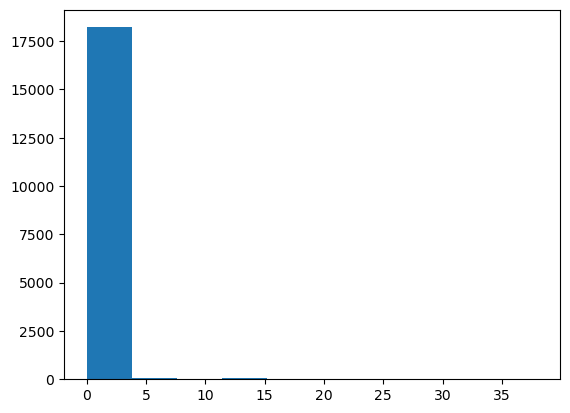

In [148]:
plt.hist(clustering_results[0])

**Прогнозирование**

In [149]:
# config = tf.compat.v1.ConfigProto()# device_count = {'GPU': 1 , 'CPU': 16} ) 
# sess = tf.compat.v1.Session(config=config) 
# sess.gpu_options.allow_growth = True
# # tf.compat.v1.keras.backend.set_session(sess)


In [238]:
W=5

In [195]:
forecasting_training_results = [Forecasting.apply_forecasting_training_simple_version(dataset_train, cur_cluster_labels, W=W) for cur_cluster_labels in clusters_labels]
models = [x[0] for x in forecasting_training_results]
results_training = [x[1] for x in forecasting_training_results]
metrics_training = [x[2] for x in forecasting_training_results]

N_clusters=39
dataset_windows.shape=(18377, 1, 21, 60), labels.shape=(18377,)
IN Clustering.split_to_clusters: mask.sum()=17950, 17950
IN Clustering.split_to_clusters: mask.sum()=166, 166
IN Clustering.split_to_clusters: mask.sum()=56, 56
IN Clustering.split_to_clusters: mask.sum()=22, 22
IN Clustering.split_to_clusters: mask.sum()=12, 12
IN Clustering.split_to_clusters: mask.sum()=10, 10
IN Clustering.split_to_clusters: mask.sum()=13, 13
IN Clustering.split_to_clusters: mask.sum()=9, 9
IN Clustering.split_to_clusters: mask.sum()=8, 8
IN Clustering.split_to_clusters: mask.sum()=7, 7
IN Clustering.split_to_clusters: mask.sum()=7, 7
IN Clustering.split_to_clusters: mask.sum()=6, 6
IN Clustering.split_to_clusters: mask.sum()=36, 36
IN Clustering.split_to_clusters: mask.sum()=4, 4
IN Clustering.split_to_clusters: mask.sum()=3, 3
IN Clustering.split_to_clusters: mask.sum()=3, 3
IN Clustering.split_to_clusters: mask.sum()=2, 2
IN Clustering.split_to_clusters: mask.sum()=2, 2
IN Clustering.sp


KeyboardInterrupt



In [239]:
# # without clustering
cur_cluster_labels = np.zeros(dataset_train.shape[0])
forecasting_training_results = [Forecasting.apply_forecasting_training_simple_version(dataset_train, cur_cluster_labels, W=W)]
models = [x[0] for x in forecasting_training_results]
results_training = [x[1] for x in forecasting_training_results]
metrics_training = [x[2] for x in forecasting_training_results]

N_clusters=1
dataset_windows.shape=(18392, 1, 6, 60), labels.shape=(18392,)
IN Clustering.split_to_clusters: mask.sum()=18392, 18392
In split_to_train_test: dataset_X.shape=(18392, 5, 60), dataset_y.shape=(18392, 60)
Epoch 1/100
173/173 [==============================] - 4s 18ms/step - loss: 0.2517 - val_loss: 0.2794
Epoch 2/100
173/173 [==============================] - 3s 18ms/step - loss: 0.2424 - val_loss: 0.2732
Epoch 3/100
173/173 [==============================] - 3s 19ms/step - loss: 0.2362 - val_loss: 0.2688
Epoch 4/100
173/173 [==============================] - 3s 18ms/step - loss: 0.2319 - val_loss: 0.2655
Epoch 5/100
173/173 [==============================] - 3s 19ms/step - loss: 0.2287 - val_loss: 0.2630
Epoch 6/100
173/173 [==============================] - 3s 18ms/step - loss: 0.2264 - val_loss: 0.2610
Epoch 7/100
173/173 [==============================] - 3s 18ms/step - loss: 0.2245 - val_loss: 0.2593
Epoch 8/100
173/173 [==============================] - 3s 19ms/step -

173/173 [==============================] - 3s 18ms/step - loss: 0.1950 - val_loss: 0.2332
Epoch 79/100
173/173 [==============================] - 3s 18ms/step - loss: 0.1949 - val_loss: 0.2332
Epoch 80/100
173/173 [==============================] - 3s 18ms/step - loss: 0.1949 - val_loss: 0.2332
Epoch 81/100
173/173 [==============================] - 3s 18ms/step - loss: 0.1948 - val_loss: 0.2331
Epoch 82/100
173/173 [==============================] - 3s 18ms/step - loss: 0.1947 - val_loss: 0.2331
Epoch 83/100
173/173 [==============================] - 3s 18ms/step - loss: 0.1946 - val_loss: 0.2331
Epoch 84/100
173/173 [==============================] - 3s 18ms/step - loss: 0.1945 - val_loss: 0.2331
Epoch 85/100
173/173 [==============================] - 3s 18ms/step - loss: 0.1945 - val_loss: 0.2331
Epoch 86/100
173/173 [==============================] - 3s 18ms/step - loss: 0.1944 - val_loss: 0.2330
Epoch 87/100
173/173 [==============================] - 3s 18ms/step - loss: 0.1943 - 

In [240]:
Q = dataset_train.shape[-1]

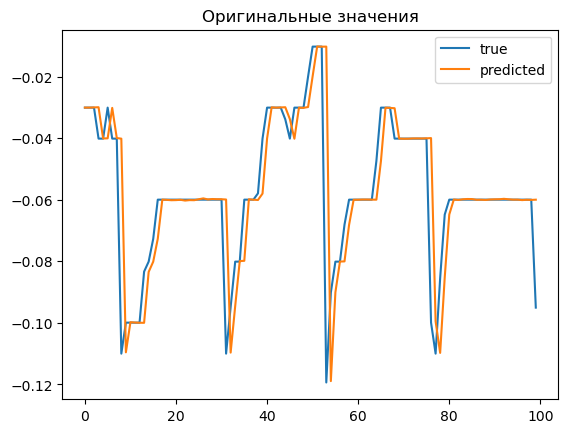

In [241]:
plt.plot(results_training[0][:100, 8], label="true")
plt.plot(results_training[0][:100, Q+8], label="predicted")
plt.legend()
plt.title("Оригинальные значения")
plt.show()

In [218]:
# tf.debugging.set_log_device_placement(True)

In [219]:
#пока без глобального теста

Результаты

In [220]:
TRAIN_MODE, VALID_MODE, TEST_MODE, GLOBAL_TEST_MODE = [0, 1, 2, 3]

In [242]:
full_results = results_training

In [243]:
[(x.shape, x[x[:, -1] == TEST_MODE].shape) for x in full_results]

[((18392, 122), (3678, 122))]

In [244]:
# global_metrics = [Forecasting.calc_metrics_for_full_results(x) for x in full_results]
global_metrics = [Forecasting.calc_metrics_for_full_results(x[x[:, -1] == TEST_MODE]) for x in full_results]

In [245]:
clusters_sizes = [np.array([np.sum(x[:, -2] == i) for i in range(len(np.unique(x[:, -2])))]) for x in full_results]
N_clusters = [len(x) for x in clusters_sizes]
print(N_clusters)

[1]


In [246]:
maes = np.array([global_metrics[i]['mae'] for i in range(len(full_results))])
mases = np.array([global_metrics[i]['mase'] for i in range(len(full_results))])
mae_on_max_cluster = np.array([
        Forecasting.calc_metrics_for_full_results(
            full_results[i][full_results[i][:, -2] == np.argmax(clusters_sizes[i])]
        )['mae'] 
    for i in range(len(full_results))])
mase_on_max_cluster = np.array([
        Forecasting.calc_metrics_for_full_results(
            full_results[i][full_results[i][:, -2] == np.argmax(clusters_sizes[i])]
        )['mase'] 
    for i in range(len(full_results))])

In [247]:
mae_on_max_cluster.shape, len(full_results)

((1, 60), 1)

In [248]:
print("MAE", np.around(np.mean(mae_on_max_cluster, axis=1),decimals=3))
print("MASE", np.around(np.mean(mase_on_max_cluster, axis=1),decimals=3))


MAE [1.53]
MASE [0.93]


In [249]:
print(np.around(np.mean([x['mase'] for x in global_metrics], axis=1), decimals=3))

[87845226.73]


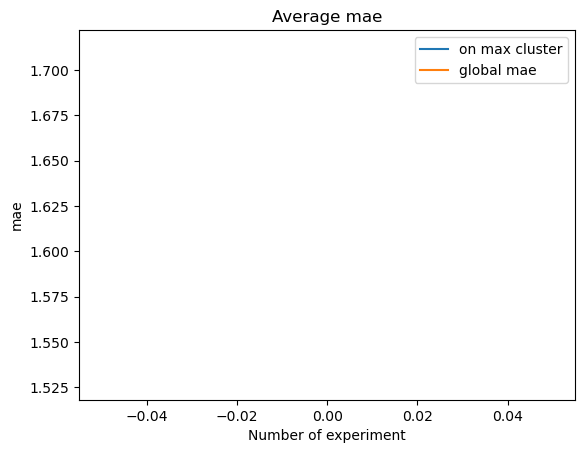

In [229]:
plt.plot(np.mean(mae_on_max_cluster, axis=1), label="on max cluster")
plt.plot(np.mean(maes, axis=1), label="global mae")
plt.legend()
plt.title("Average mae")
plt.ylabel("mae")
plt.xlabel("Number of experiment")
plt.show()

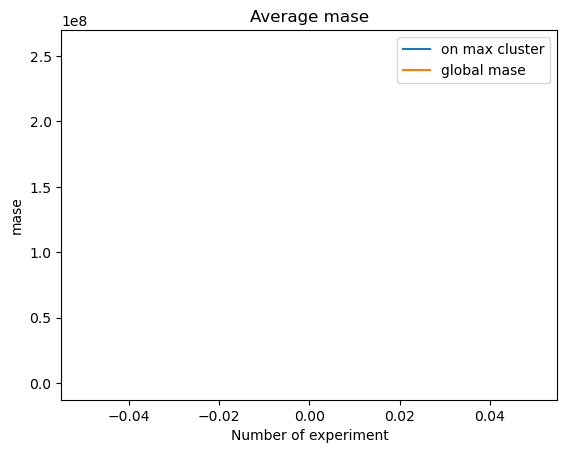

In [230]:
plt.plot(np.mean(mase_on_max_cluster, axis=1), label="on max cluster")
plt.plot(np.mean(mases, axis=1), label="global mase")
plt.legend()
plt.title("Average mase")
plt.ylabel("mase")
plt.xlabel("Number of experiment")
plt.show()

In [231]:
np.mean(mases, axis=1)

array([2.56969531e+08])

In [250]:
ind1 = np.argmin(np.mean(mae_on_max_cluster, axis=1))
ind1

0

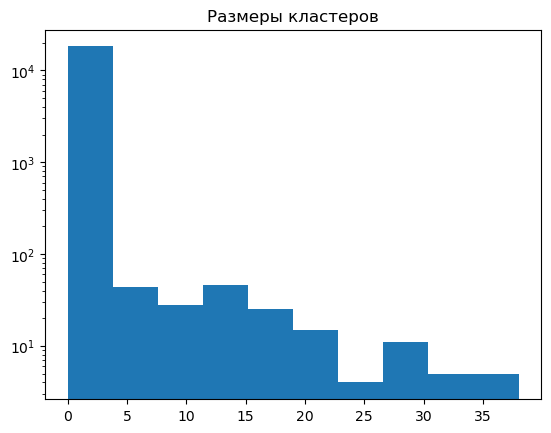

In [233]:
plt.hist(clusters_labels[ind1])
plt.title("Размеры кластеров")
plt.yscale("log")
plt.show()

In [251]:
np.mean(global_metrics[ind1]['mase'])

87845226.73018664

Запись

In [235]:
algs = [x[0] for x in cluster_algs]
ns = N_clusters
ws = [x[1] for x in cluster_algs]

In [236]:
[(algs[i], ws[i], ns[i]) for i in range(len(algs))]

IndexError: list index out of range

In [175]:
assert(len(full_results) == len(algs))

In [176]:
import csv
for IND in range(len(full_results)):
    with open(f"./pulp/W30_group1/{IND+20:02}_{algs[IND]}_N{ns[IND]}_w{ws[IND]}.csv", "w") as fout:
        writer = csv.writer(fout)
        writer.writerow(["real "+str(i) for i in range(Q)] + ["predicted " + str(i) for i in range(Q)] + ["cluster_num", "mode"])
        for i in range(full_results[IND].shape[0]):
            writer.writerow(full_results[IND][i])


In [192]:
len(full_results)

1

In [252]:
IND=0
with open(f"./pulp/W5_original.csv", "w") as fout:
    writer = csv.writer(fout)
    writer.writerow(["real "+str(i) for i in range(Q)] + ["predicted " + str(i) for i in range(Q)] + ["cluster_num", "mode"])
    for i in range(full_results[IND].shape[0]):
        writer.writerow(full_results[IND][i])